# Developping the python Class for joining dataset. 

This includes a basic utils functions for preprocessing of the data and the attribution class.

In [98]:
from typing import List, Dict, Tuple, Set, Optional, Callable
import geopandas as gpd
import dask_geopandas as dgpd
import pandas as pd
import dask.dataframe as dd
import numpy as np


#write a function that verify if the input is a valid GeoDataFrame, meaning that it has a geometry column, a definied crs and a non-empty geometry column, a 'class' column (string) and a valid index column (int) and two datetimes
def is_dataset_valid(name: str, dataset: gpd.GeoDataFrame, ref=False) -> bool:
    assert isinstance(dataset, gpd.GeoDataFrame), f"dataset '{name}' is not a GeoDataFrame"
    assert 'geometry' in dataset.columns, f"dataset '{name}' has no geometry column"
    assert dataset.crs is not None, f"dataset '{name}' has no crs"
    assert dataset.index.dtype == int, f"dataset '{name}' has no valid index column"
    if not ref:
        assert 'class' in dataset.columns, f"dataset '{name}' has no class column"
        dataset['class'] = dataset['class'].astype(str)

    #check if the 'start_date' and 'end_date' columns are present, if not check if a column 'year' is present
    if 'start_date' not in dataset.columns:
        assert 'year' in dataset.columns, f"dataset '{name}' has no start_date or year column"

        #if year in column, create a start_date and end_date column as the first and last day of this year
        dataset['start_date'] = pd.to_datetime(dataset['year'], format='%Y')
        dataset['end_date'] = pd.to_datetime(dataset['year'], format='%Y') + pd.offsets.YearEnd(0)
        


    assert 'start_date' in dataset.columns, f"dataset '{name}' has no start_date column"
    assert 'end_date' in dataset.columns, f"dataset '{name}' has no end_date column"
    dataset['start_date'] = pd.to_datetime(dataset['start_date'], format='%Y-%m-%d')
    dataset['end_date'] = pd.to_datetime(dataset['end_date'], format='%Y-%m-%d')
    dataset['dataset'] = name
    
    return dataset 

def get_spatial_join(dataset: gpd.GeoDataFrame, reference: gpd.GeoDataFrame, t: str, spatial_buffer: int) -> gpd.GeoDataFrame:

    if t == 'point':
        return dataset.sjoin_nearest(reference.compute(), max_distance=spatial_buffer, distance_col='sd')
    
    elif t == 'polygon':
        return dataset.sjoin(reference)
    

class Attribution:
    #ddataset is a dict containing the name of the dataset and the GeoDataframe
    #reference is a GeoDataframe containing the reference data
    #doa is a dict containing the overall accuracy of each dataset 
    #dweights is a dict containing the weight function for each factor 

    #write the init method with typing
    def __init__(self, ddataset: Dict[str, gpd.GeoDataFrame], reference: gpd.GeoDataFrame, 
    doa: Dict[str, float], dtypes: Dict[str, str], temporal_buffer: int, dsbuffer: Dict[str, int]):
        
        self.mandatory_columns = ['start_date', 'end_date', 'class', 'dataset', 'year']
        self.ddataset = ddataset
        for name, dataset in self.ddataset.items():
            self.ddataset[name] = is_dataset_valid(name, dataset)

        self.reference = is_dataset_valid('reference', reference, ref=True) 
        self.optional_columns = self.get_optional_columns()

        
        self.doa = doa
        self.temporal_buffer = temporal_buffer #years
        self.dsbuffer = dsbuffer #km 
        self.dtypes = dtypes

        assert self.ddataset.keys() == self.doa.keys(), "doa keys are not the same as ddataset keys"
        assert self.ddataset.keys() == self.dtypes.keys(), "dtypes keys are not the same as ddataset keys"  
        assert self.ddataset.keys() == self.dsbuffer.keys(), "dsbuffer keys are not the same as ddataset keys"
        assert all([self.ddataset[name].crs == self.reference.crs for name in self.ddataset.keys()]), "not all the geodataframe have the same crs"

    def get_optional_columns(self) -> List[str]:
        cols = []
        for dataset in self.ddataset.values():
            cols.extend(dataset.columns.difference(self.mandatory_columns).values.tolist())

        optional_cols = []
        for col in list(set(cols)):
            if col in self.reference.columns and col != 'geometry':
                self.mandatory_columns.append(col)
            elif col != 'geometry':
                optional_cols.append(col)

        return optional_cols

    #write a method that returns the temporal and spatial join
    def get_spatial_joins(self, ddataset_year: Dict[str, dgpd.GeoDataFrame or gpd.GeoDataFrame], reference_year: dgpd.GeoDataFrame) -> gpd.GeoDataFrame:
        
        #SPATIAL JOIN ~ 10s
        dtsj = []
        for (name, dataset) in ddataset_year.items():
            t = self.dtypes[name]
            dtsj.append(get_spatial_join(dataset, reference_year, t, self.dsbuffer[name]))

        concat1 = dd.concat(dtsj, axis=0).compute()

        #CONCATENATION WITH REF ~ 1s
        col = ['geometry'] + [col + '_left' for col in self.mandatory_columns] + [col for col in self.optional_columns] + ['sd']
        all_index_right = concat1['index_right'].unique()
        concat1 = concat1[['index_right']+col]
        rename = {c: c.split('_left')[0] for c in col}
        concat1 = concat1.rename(columns=rename)
        reference_year['index_right'] = reference_year.index

        #order of reference and concat1 is important. If we want to use iloc[0] on the group to retrieve reference row, we have to stick to this order.
        concat2 = dd.concat([reference_year.loc[all_index_right], concat1], axis=0).compute()

        #MERGING ~ 1s 
        merge = pd.merge(concat2, reference_year.compute(), left_on='index_right', right_index=True)
        drop = ['geometry_y','index_right_y', 'index_right_x'] + [col + '_y' for col in self.mandatory_columns] 
        merge = merge.drop(columns=drop)
        rename = {c: c.split('_x')[0] for c in merge.columns} 
        rename.update({'index_right': 'index_reference'})
        return merge.rename(columns=rename).reset_index()


# Loading dataset

In [4]:
import geopandas as gpd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_DFDE_1984_2021_EPSG2154_FR.parquet')
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet')
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet')
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet")
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2015_2022_FR_EPSG2154.parquet')
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')

In [18]:
#preprocessing bdiff:
bdiff['class'] = 'Fire'

#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

In [71]:
#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

In [130]:
#defining the class 

from thefuzz import fuzz

def spatial_weight(x) -> float:
    if x <= 1:
        return 1
    else: 
        return 1 - (x-1)/9 
    
def temporal_weight(x) -> float:
    if x <= 3:
        return 1 - x/12
    else: 
        return 0.75 * (1 - (x-3)/3)

def compute_tree_coherence(row_tt, row_e, ref_tt, ref_e) -> float:

    for essence in ref_e.split(','):
        if fuzz.token_set_ratio(row_e.lower(), essence.lower()) > 80:
            return 1
        
    if row_tt.lower() == ref_tt.lower():
        return 0.75 
    
    if row_tt.lower() == 'mixed' or ref_tt.lower() == 'mixed':
        return 0.5

    return 0.25 



ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon'}
doa = {'dfde': 0.95, 'hm': 1.0, 'nfi': 0.75, 'senfseidl': 0.88, 'bdiff': 0.95}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None}
temporal_buffer = 5

attribution = Attribution(ddataset, tcl, doa, dtypes, temporal_buffer, dsbuffer)

In [131]:
#Temporal buffer 
import dask_geopandas as dgpd
year = 2019
ddataset_year = {}
for name, dataset in attribution.ddataset.items():
    t = attribution.dtypes[name]
    d = dataset[(dataset['start_date'].dt.year >= year - temporal_buffer) & (dataset['end_date'].dt.year <= year + temporal_buffer)]
    if t == 'point':
        ddataset_year[name] = d
    elif t == 'polygon':
        ddataset_year[name] = dgpd.from_geopandas(d, npartitions=10)

reference_year = attribution.reference[ attribution.reference['year'] == year ]
reference_year = dgpd.from_geopandas(reference_year, npartitions=10)


In [132]:
attribution_year = attribution.get_spatial_joins(ddataset_year, reference_year)


In [133]:
attribution_year.dataset.value_counts()

dataset
bdiff        318832
senfseidl    243846
reference    108851
hm            15885
nfi           11385
dfde           5853
Name: count, dtype: int64[pyarrow]

## Visualisation

In [134]:
groups = attribution_year.groupby('index_reference')

from itertools import islice 

gr = []
for name, group in islice(groups, 0, 1000):
    gr.append(group)

In [135]:
[i for i,r in enumerate(gr) if len(r.dataset.unique()) > 3 ]

[32,
 70,
 117,
 128,
 131,
 177,
 185,
 229,
 246,
 260,
 375,
 389,
 418,
 425,
 577,
 594,
 634,
 698,
 762,
 794,
 805,
 807,
 810,
 820,
 834,
 888,
 924,
 955,
 971,
 978,
 994]

In [129]:
data = gr[222]

try:
    data['start_date'] = data['start_date'].dt.strftime('%Y-%m-%d')
except :
    pass 

try:
    data['end_date'] = data['end_date'].dt.strftime('%Y-%m-%d')
except : 
    pass

data.explore(column = 'dataset', 
             tooltip = ['year', 'start_date', 'end_date', 'essence', 'class', 'notes'], 
             tiles = 'Esri.WorldImagery',
             marker_kwds=dict(radius=5, fill=True))

## Group clasification

Computation of similiarity matrix in the followings spaces : 
- x
- y 
- start-date
- end-date
- tree-specie
- class

In [136]:
groups = attribution_year.groupby('index_reference')

from itertools import islice 

gr = []
for name, group in islice(groups, 0, 1000):
    gr.append(group)

In [137]:
[i for i,r in enumerate(gr) if len(r.dataset.unique()) > 3 ]

[32,
 70,
 117,
 128,
 131,
 177,
 185,
 229,
 246,
 260,
 375,
 389,
 418,
 425,
 577,
 594,
 634,
 698,
 762,
 794,
 805,
 807,
 810,
 820,
 834,
 888,
 924,
 955,
 971,
 978,
 994]

### Weights design

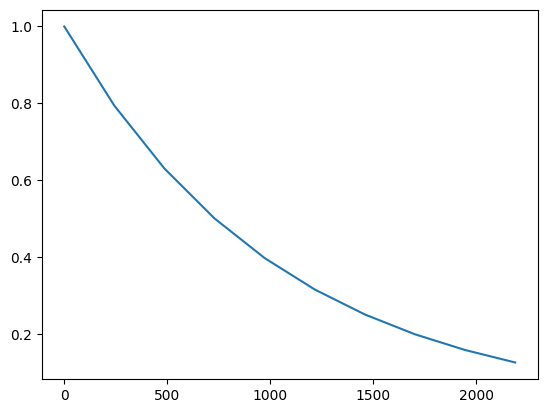

In [194]:
import numpy as np

def exponential_decay(days: int, half_life: int) -> float:
    return np.exp(-np.log(2) * days / half_life)

half_life = 2 * 365
a = np.linspace(0, 6*365, 10)

import matplotlib.pyplot as plt
plt.plot(a, exponential_decay(a, half_life))


### Similarity matrix

In [262]:
data = gr[762]

In [342]:
#spatial weights
def spatial_weight(x) -> float:
    if x <= 500:
        return 1
    else: 
        return 1 - (x-500)/9500
    
v_spatial_weight = np.vectorize(spatial_weight, otypes=['float'])

#temporal weights
def temporal_weight(x) -> float:
    x = x/365 
    if x <= 3:
        return 1 - x/12
    else: 
        return 0.75 * (1 - (x-3)/3)
    
vectorized_temporal_weight = np.vectorize(temporal_weight, otypes=['float'])

def compute_tree_coherence(row1, row2) -> float:

    for essence1 in row1['essence'].split(','):
        for essence2 in row2['essence'].split(','):
            if fuzz.token_set_ratio(essence1.lower(), essence2.lower()) > 80:
                return 1
        
    if row1['tree_type'].lower() == row2['tree_type'].lower():
        return 0.75 
    
    if row1['tree_type'].lower() == 'mixed' or row2['tree_type'].lower() == 'mixed':
        return 0.5

    return 0.25 

# Function to build the similarity matrix
def build_tree_coherence_matrix(df):
    n = len(df)
    # Initialize the similarity matrix with zeros
    coherence_matrix = np.zeros((n, n))
    
    # Iterate over each pair of rows
    for i in range(n):
        for j in range(i, n):  # Use range(i, n) to avoid redundant computations
            # Compute the tree coherence for each pair of rows
            coherence = compute_tree_coherence(df.iloc[i], df.iloc[j])
            # Fill in the matrix, it's symmetric so we can do both i,j and j,i
            coherence_matrix[i, j] = coherence
            coherence_matrix[j, i] = coherence

    return coherence_matrix

def category_based_similarity(class1, class2, dataset1, dataset2, dclass):
    lclass1 = dclass[dataset1][class1]
    lclass2 = dclass[dataset2][class2]
    
    for c1 in lclass1:
        for c2 in lclass2:
            if c1 == c2:
                return 1
    if ('biotic' in ' '.join(lclass1) and 'biotic' in ' '.join(lclass2)) or \
          ('dieback' in ' '.join(lclass1) and 'dieback' in ' '.join(lclass2)) :
        return 0.75
    if (('storm' in ' '.join(lclass1) or 'biotic' in ' '.join(lclass1)) and \
             ('storm' in ' '.join(lclass2) or 'biotic' in ' '.join(lclass2))):
        return 0.5
    else :
        return 0.25
    
# Function to build the similarity matrix
def build_class_matrix(df):
    n = len(df)
    # Initialize the similarity matrix with zeros
    coherence_matrix = np.zeros((n, n))
    
    # Iterate over each pair of rows
    for i in range(n):
        for j in range(i, n):  # Use range(i, n) to avoid redundant computations
            # Compute the tree coherence for each pair of rows
            coherence = category_based_similarity(df['class'].iloc[i], df['class'].iloc[j], df['dataset'].iloc[i], df['dataset'].iloc[j], dclass)
            # Fill in the matrix, it's symmetric so we can do both i,j and j,i
            coherence_matrix[i, j] = coherence
            coherence_matrix[j, i] = coherence

    return coherence_matrix

import numpy as np
dclass ={
    'senfseidl': {
        'Storm,Biotic': ['biotic-mortality', 'storm'],
        'Fire' : ['fire'],
        'Other' : ['biotic-dieback', 'drought-dieback', 'antropogenic']
    },
    'dfde': {
        'Biotic':['biotic-mortality', 'biotic-dieback'],
        'Storm':['storm'],
        'Fire':['fire'],
        'Drought':['drought-dieback'],
        'Other':['antropogenic']
    },
    'nfi': {
        'Biotic-dieback':['biotic-dieback'],
        'Biotic-mortality':['biotic-mortality'],
        'Storm':['storm'],
        'Fire':['fire'],
        'Drought':['drought-dieback'],
        'Other':['antropogenic'],
        'Tree-logging':['antropogenic']
    },
    'hm': {
        'Biotic':['biotic-mortality', 'biotic-dieback'],
        'Storm':['storm'],
        'Fire':['fire'],
        'Drought-dieback':['drought-dieback'],
        'Other':['antropogenic']
    },
    'bdiff': {
        'Fire':['fire']
    },
    'reference': {
        'None':['biotic-mortality', 'biotic-dieback', 'storm', 'fire', 'drought-dieback', 'antropogenic']
    }
}
def compute_similarity_matrix(data, weights = {'x':1, 'y':1, 'start_date':1, 'end_date':1, 'tree_coherence':1, 'class':1}):

    #turn None to 'None' in class column
    data = data.fillna('None')
    matrices = {}
    data['x'] = data['geometry'].centroid.x
    data['y'] = data['geometry'].centroid.y

    matrices['x'] = v_spatial_weight(np.abs(data['x'].values.reshape(-1, 1) - data['x'].values))
    matrices['y'] = v_spatial_weight(np.abs(data['y'].values.reshape(-1, 1) - data['y'].values))

    start_date_matrix = data['start_date'].values.astype('datetime64[D]').reshape(-1, 1)
    day_diff_matrix = np.abs((start_date_matrix - start_date_matrix.T) / np.timedelta64(1, 'D'))
    matrices['start_date'] = vectorized_temporal_weight(day_diff_matrix)

    end_date_matrix = data['end_date'].values.astype('datetime64[D]').reshape(-1, 1)
    day_diff_matrix = np.abs((end_date_matrix - end_date_matrix.T) / np.timedelta64(1, 'D'))
    matrices['end_date'] = vectorized_temporal_weight(day_diff_matrix)

    # Use the function to build the matrix
    matrices['tree_coherence'] = build_tree_coherence_matrix(data)

    # Define a simple category-based similarity function
    matrices['class'] = build_class_matrix(data)

    # Compute the weighted average
    return np.average(np.array(list(matrices.values())), axis=0, weights=list(weights.values())), matrices

from sklearn.cluster import SpectralClustering

from collections import defaultdict


def get_predominant_class(l):
    if len(l) == 1:
        return l[0][0]
    elif len(np.unique([l[0] for l in l])) > 1:
        # Step 1: Group by class and calculate sum of similarities and count
        class_stats = defaultdict(lambda: {'count': 0, 'similarity_sum': 0.0})
        for entry in l:
            class_name, similarity = entry
            class_stats[class_name]['count'] += 1
            class_stats[class_name]['similarity_sum'] += similarity

        # Step 2: Calculate average similarity for each class
        for class_name, stats in class_stats.items():
            stats['average_similarity'] = stats['similarity_sum'] / stats['count']

        # Step 3: Determine the class with the highest frequency
        # Step 4: If there's a tie, use average similarity
        sorted_classes = sorted(class_stats.items(), key=lambda item: (-item[1]['count'], -item[1]['average_similarity']))
        return sorted_classes[0][0]
    else :
        return 'multi-factor'

def get_cluster(data, threshold=0.5):

    similarity_matrix, _ = compute_similarity_matrix(data)

    #compute clusters 
    c = []
    for i in range(1, len(data)):
        c.extend(dclass[data.iloc[i]['dataset']][data.iloc[i]['class']])

    l, c = np.unique(c, return_counts=True)

    n_clusters = max(1,len(data.iloc[1:]['class'].unique()) - len([x for x in c if x > 1])) #number of unique classes - number of classes that are present in more than one dataset
    # Perform spectral clustering
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
    labels = sc.fit_predict(similarity_matrix)
    data['labels'] = labels

    # Unique cluster labels
    cluster_labels = data['labels'].iloc[1:]
    unique_labels = np.unique(cluster_labels)

    # Dictionary to hold the sum of scores and the count for each cluster
    cluster_sums = {label: {'sum': 0, 'count': 0, 'class': []} for label in unique_labels}

    # Sum scores and counts for each cluster
    for i, (score, label) in enumerate(zip(similarity_matrix[0][1:], cluster_labels)):
        ws = score * doa[data['dataset'].iloc[i+1]]
        cluster_sums[label]['sum'] += ws 
        cluster_sums[label]['count'] += 1
        cluster_sums[label]['class'].extend([(x,ws) for x in dclass[data['dataset'].iloc[i+1]][data['class'].iloc[i+1]]])

    # Compute average score for each cluster
    average_scores = {label: (cluster_sums[label]['sum'] / cluster_sums[label]['count']) for label in cluster_sums}
    timeperiod_group = {}
    data_ = data.iloc[1:].copy()
    data_['start_date'] = pd.to_datetime(data_['start_date'], format='%Y-%m-%d')
    data_['end_date'] = pd.to_datetime(data_['end_date'], format='%Y-%m-%d')

    #get date of the median start and end date for each cluster
    for group in data_['labels'].unique():
        group_df = data_[data_['labels'] == group]
        median_start = group_df['start_date'].median()
        median_end = group_df['end_date'].median()
        timeperiod_group[group] = (median_start, median_end)

    for label in average_scores:
        average_scores[label] = (average_scores[label], get_predominant_class(cluster_sums[label]['class']), timeperiod_group[label])

    # Filter the dictionary based on similarity score > 0.5
    filtered_d = {k: v for k, v in average_scores.items() if v[0] > threshold}

    # Convert the filtered dictionary into a DataFrame
    df = pd.DataFrame.from_dict(filtered_d, orient='index', columns=['Similarity', 'Class', 'TimePeriod'])

    # Ensure the dates are in the correct format (if they are strings)
    df['Start_Date'], df['End_Date'] = zip(*df['TimePeriod'])
    df = df.drop('TimePeriod', axis=1)

    # Convert the string dates to datetime objects if needed
    df['Start_Date'] = pd.to_datetime(df['Start_Date'], dayfirst=True)
    df['End_Date'] = pd.to_datetime(df['End_Date'], dayfirst=True)

    df[['geometry', 'detection_year','tree_type', 'essence']] = data.iloc[0][['geometry', 'year','tree_type', 'essence']]
    return df.sort_values(by='Similarity', ascending=False)


In [346]:
#remove warning 
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
for i in tqdm(range(1000)):
    data = gr[i]
    # similarity_matrix, matrices = compute_similarity_matrix(data)
    df = get_cluster(data, threshold=0.)

100%|██████████| 1000/1000 [00:37<00:00, 26.50it/s]


In [344]:
get_cluster(gr[762], threshold=0.)

,Similarity,Class,Start_Date,End_Date,geometry,detection_year,tree_type,essence
0,0.831111,biotic-dieback,2017-01-01,2017-12-31,"POLYGON ((760825.7887934734 6990451.896391112,...",2019.0,Mixed,"mixed,fir, spruce"
1,0.754083,fire,2015-01-01,2015-12-31,"POLYGON ((760825.7887934734 6990451.896391112,...",2019.0,Mixed,"mixed,fir, spruce"
2,0.595481,antropogenic,2014-12-27,2019-12-28,"POLYGON ((760825.7887934734 6990451.896391112,...",2019.0,Mixed,"mixed,fir, spruce"


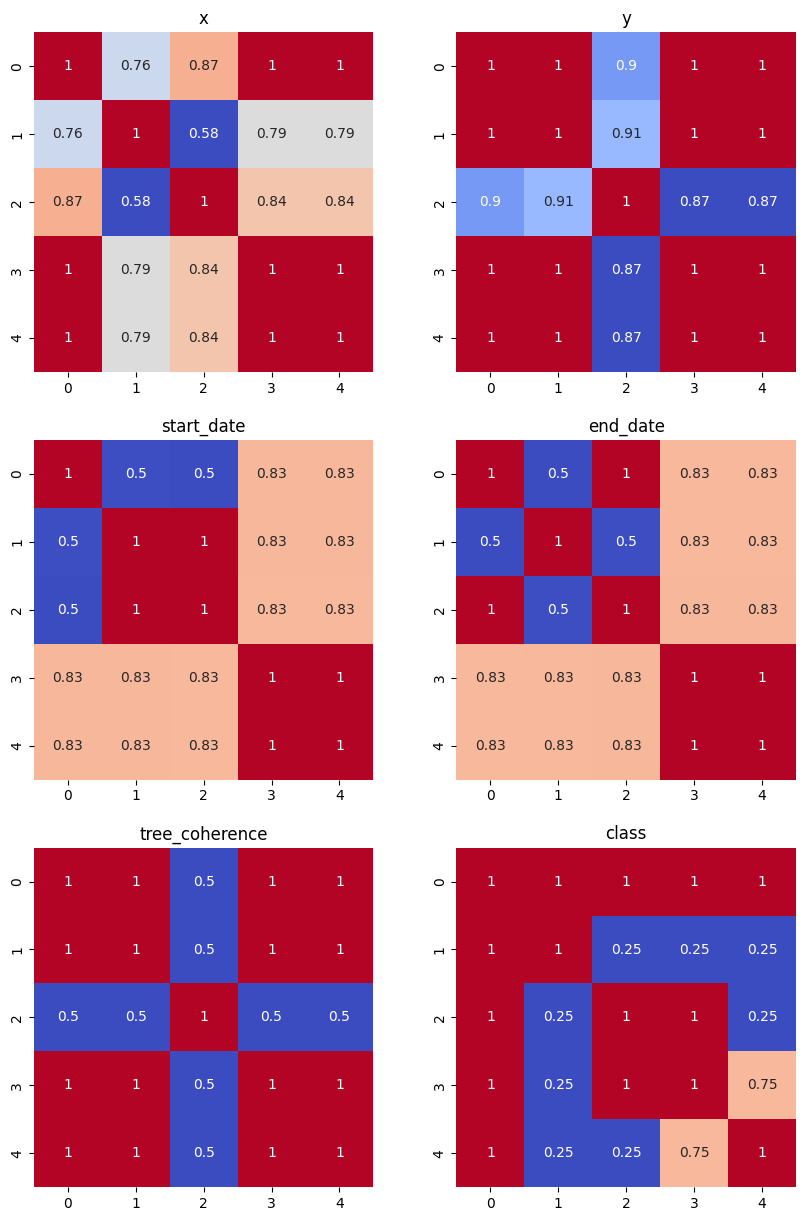

In [313]:
import seaborn as sns
import matplotlib.pyplot as plt

data = gr[762]
similarity_matrix, matrices = compute_similarity_matrix(data, weights = {'x':1, 'y':1, 'start_date':1, 'end_date':1, 'tree_coherence':1, 'class':1})
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

axes_ = [ (0,0), (0,1), (1,0), (1,1), (2,0), (2,1) ]

for ax, (name, matrices) in zip(axes_, matrices.items()):
    axes[ax].set_title(name)
    sns.heatmap(matrices, annot=True, cmap='coolwarm', square=True, ax=axes[ax], cbar=False)




In [320]:
data

,index,index_reference,geometry,year,tree_type,essence,class,start_date,end_date,dataset,name,area,cause,notes,forest_area_m2,sd,labels
15501,1083786,1083786,"POLYGON ((760825.789 6990451.896, 760826.386 6...",2019.0,Mixed,"mixed,fir, spruce",<NA>,2019-01-01,2019-12-31,reference,<NA>,NaN,<NA>,<NA>,NaN,NaN,1
15502,4497,1083786,"POLYGON ((752770.586 6989630.657, 752787.739 6...",2015.0,Mixed,"broadleaf,poplar,mixed,fir, spruce,deciduous o...",Fire,2015-01-01,2015-12-31,bdiff,"Le Nouvion-en-Thiérache, Vervins, Aisne, Hauts...",NaN,<NA>,<NA>,1000.0,NaN,2
15503,81997,1083786,POINT (762529.545 6988939.727),NaN,Broadleaf,Pedunculate Oak,Tree-logging,2014-12-27,2019-12-28,nfi,<NA>,NaN,<NA>,<NA>,NaN,2241.017324,0
15504,1648792,1083786,"POLYGON ((760499.585 6990846.048, 760559.404 6...",2017.0,Mixed,"mixed,broadleaf,nr,fir, spruce",Other,2017-01-01,2017-12-31,senfseidl,<NA>,NaN,<NA>,<NA>,NaN,0.000000,1
15505,1721996,1083786,"POLYGON ((760436.961 6990870.256, 760496.779 6...",2017.0,Mixed,"mixed,broadleaf,nr,fir, spruce","Storm,Biotic",2017-01-01,2017-12-31,senfseidl,<NA>,NaN,<NA>,<NA>,NaN,0.000000,1


<Axes: >

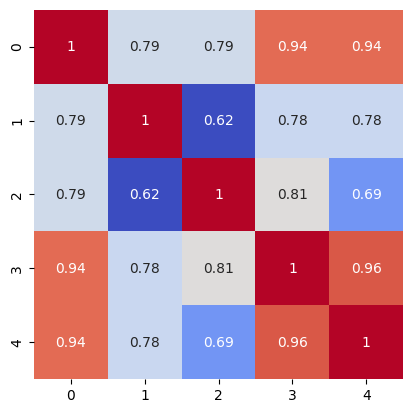

In [314]:
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', square=True, cbar=False)

In [315]:
from sklearn.cluster import SpectralClustering

c = []
for i in range(1, len(data)):
    c.extend(dclass[data.iloc[i]['dataset']][data.iloc[i]['class']])

l, c = np.unique(c, return_counts=True)

n_clusters = len(data.iloc[1:]['class'].unique()) - len([x for x in c if x > 1]) #number of unique classes - number of classes that are present in more than one dataset
# Perform spectral clustering
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
labels = sc.fit_predict(similarity_matrix)


In [323]:


data['labels'] = labels

# Unique cluster labels
cluster_labels = data['labels'].iloc[1:]
unique_labels = np.unique(cluster_labels)

# Dictionary to hold the sum of scores and the count for each cluster
cluster_sums = {label: {'sum': 0, 'count': 0, 'class': []} for label in unique_labels}

# Sum scores and counts for each cluster
for i, (score, label) in enumerate(zip(similarity_matrix[0][1:], cluster_labels)):
    ws = score * doa[data['dataset'].iloc[i+1]]
    cluster_sums[label]['sum'] += ws 
    cluster_sums[label]['count'] += 1
    cluster_sums[label]['class'].extend([(x,ws) for x in dclass[data['dataset'].iloc[i+1]][data['class'].iloc[i+1]]])

# Compute average score for each cluster
average_scores = {label: (cluster_sums[label]['sum'] / cluster_sums[label]['count']) for label in cluster_sums}
timeperiod_group = {}
data_ = data.iloc[1:].copy()
data_['start_date'] = pd.to_datetime(data_['start_date'], format='%Y-%m-%d')
data_['end_date'] = pd.to_datetime(data_['end_date'], format='%Y-%m-%d')

for group in data_['labels'].unique():
    group_df = data_[data_['labels'] == group]
    median_start = group_df['start_date'].median()
    median_end = group_df['end_date'].median()
    timeperiod_group[group] = (median_start, median_end)

for label in average_scores:
    average_scores[label] = (average_scores[label], get_predominant_class(cluster_sums[label]['class']), timeperiod_group[label])

average_scores


{0: (0.5954810364197152,
  'antropogenic',
  (Timestamp('2014-12-27 00:00:00'), Timestamp('2019-12-28 00:00:00'))),
 1: (0.8311111111111112,
  'biotic-dieback',
  (Timestamp('2017-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))),
 2: (0.7540825004295159,
  'fire',
  (Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-31 00:00:00')))}

In [317]:
data

,index,index_reference,geometry,year,tree_type,essence,class,start_date,end_date,dataset,name,area,cause,notes,forest_area_m2,sd,labels
15501,1083786,1083786,"POLYGON ((760825.789 6990451.896, 760826.386 6...",2019.0,Mixed,"mixed,fir, spruce",<NA>,2019-01-01,2019-12-31,reference,<NA>,NaN,<NA>,<NA>,NaN,NaN,1
15502,4497,1083786,"POLYGON ((752770.586 6989630.657, 752787.739 6...",2015.0,Mixed,"broadleaf,poplar,mixed,fir, spruce,deciduous o...",Fire,2015-01-01,2015-12-31,bdiff,"Le Nouvion-en-Thiérache, Vervins, Aisne, Hauts...",NaN,<NA>,<NA>,1000.0,NaN,2
15503,81997,1083786,POINT (762529.545 6988939.727),NaN,Broadleaf,Pedunculate Oak,Tree-logging,2014-12-27,2019-12-28,nfi,<NA>,NaN,<NA>,<NA>,NaN,2241.017324,0
15504,1648792,1083786,"POLYGON ((760499.585 6990846.048, 760559.404 6...",2017.0,Mixed,"mixed,broadleaf,nr,fir, spruce",Other,2017-01-01,2017-12-31,senfseidl,<NA>,NaN,<NA>,<NA>,NaN,0.000000,1
15505,1721996,1083786,"POLYGON ((760436.961 6990870.256, 760496.779 6...",2017.0,Mixed,"mixed,broadleaf,nr,fir, spruce","Storm,Biotic",2017-01-01,2017-12-31,senfseidl,<NA>,NaN,<NA>,<NA>,NaN,0.000000,1


In [310]:
try:
    data['start_date'] = data['start_date'].dt.strftime('%Y-%m-%d')
except :
    pass 

try:
    data['end_date'] = data['end_date'].dt.strftime('%Y-%m-%d')
except : 
    pass

data.explore(column = 'dataset', 
             tooltip = ['year', 'start_date', 'end_date', 'essence', 'class', 'notes', 'labels'], 
             tiles = 'Esri.WorldImagery',
             marker_kwds=dict(radius=5, fill=True))

# Others

In [155]:
import numpy as np
def compute_weight_on_merge(row, row_ref, dtypes, doa):
    # spatial distance, spatial weight, temporal distance, temporal weight, tree correspondance weight, overall accuracy
    
    if row['dataset'] == 'reference':
        return 0, 1, 0, 1, 1, 0, 0 
    elif dtypes[row['dataset']] == 'polygon':
        sd = (row['area'] / 1e6)** (1/2) / 35

    elif dtypes[row['dataset']] == 'point':
        sd = row['sd'] / 1e3

    oa = doa[row['dataset']]
    td = min(abs(row_ref['year'] - row['start_date'].year), abs(row['end_date'].year - row_ref['year']))
   
    tc = compute_tree_coherence(row['tree_type'], row['essence'], row_ref['tree_type'], row_ref['essence'])
    sw = spatial_weight(sd)
    tw = temporal_weight(td)

    return sd, sw, td, tw, tc, oa, np.mean([sw,tw,tc]) * oa

In [156]:
data = gr[32]
data[['sd', 'sw', 'td', 'tw', 'tc', 'oa', 'gw']] = data.apply(compute_weight_on_merge, axis=1, result_type='expand', args=(data.iloc[0], attribution.dtypes, attribution.doa))

In [157]:
data

,index,index_reference,geometry,year,tree_type,essence,class,start_date,end_date,dataset,...,cause,notes,forest_area_m2,sd,sw,td,tw,tc,oa,gw
13577,566615,566615,"POLYGON ((622612.775 7079137.226, 622612.388 7...",2019.0,Broadleaf,"beech,broadleaf",<NA>,2019-01-01 00:00:00,2019-12-31,reference,...,<NA>,<NA>,NaN,0.000000,1.000000,0.0,1.000000,1.00,0.00,0.000000
13578,43374,566615,"POLYGON ((622635.601 7079076.133, 622665.548 7...",2018.0,Broadleaf,broadleaf,Other,2018-01-01 00:00:00,2018-12-31,senfseidl,...,<NA>,<NA>,NaN,0.040535,1.000000,1.0,0.916667,1.00,0.88,0.855556
13579,43375,566615,"POLYGON ((622632.717 7079106.023, 622635.601 7...",2018.0,Broadleaf,"beech,broadleaf",Other,2018-01-01 00:00:00,2018-12-31,senfseidl,...,<NA>,<NA>,NaN,0.000000,1.000000,1.0,0.916667,1.00,0.88,0.855556
13580,59372,566615,POINT (623634.425 7078759.309),2020.0,broadleaf,Maples,Biotic,2020-01-01 00:00:00,2020-12-31,hm,...,Maladie de la suie,"5 sujets bois moyen ont été observés, mort.",NaN,1.080323,0.991075,1.0,0.916667,0.75,1.00,0.885914
13581,66485,566615,POINT (623345.381 7078072.360),NaN,Broadleaf,Pedunculate Oak,Biotic-mortality,2016-12-27 18:00:00,2021-12-28,nfi,...,<NA>,<NA>,NaN,1.258140,0.971318,2.0,0.833333,0.75,0.75,0.638663
13582,92547,566615,POINT (622362.610 7080079.704),NaN,Broadleaf,Pedunculate Oak,Biotic-mortality,2016-12-27 18:00:00,2021-12-28,nfi,...,<NA>,<NA>,NaN,0.966180,1.000000,2.0,0.833333,0.75,0.75,0.645833
13583,2014857,566615,"POLYGON ((622632.717 7079106.023, 622662.664 7...",2019.0,Broadleaf,broadleaf,Other,2019-01-01 00:00:00,2019-12-31,senfseidl,...,<NA>,<NA>,NaN,0.020602,1.000000,0.0,1.000000,1.00,0.88,0.880000
13584,2014858,566615,"POLYGON ((622659.780 7079138.817, 622689.727 7...",2019.0,Broadleaf,broadleaf,Other,2019-01-01 00:00:00,2019-12-31,senfseidl,...,<NA>,<NA>,NaN,0.047033,1.000000,0.0,1.000000,1.00,0.88,0.880000
